# Style Transfer
## Eli Laird, Clay Harper

In [1]:
# workaround for multiple OpenMP on Mac
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import tensorflow as tf
print('TF version: ', tf.__version__)
from pathlib import PurePath

import IPython.display as display
from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

import numpy as np
import time
import functools
from pprint import pprint
import PIL
from PIL import Image
from io import BytesIO
import requests
import copy

TF version:  2.4.1


## Utility Functions

In [15]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title==None:
        title = str(image.shape)
    else:
        title += ' '+str(image.shape)
    plt.title(title)


## VGG Encoder-Decoder Implementation

Here, we need to manipulate the given VGG code (courtesy of Justin Ledford) to make use of pooling layers or strided convolutions alternatively.  We chose to use strided convolutions because it is less computationally expensive.

In [3]:
import tensorflow_datasets as tfds
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg_preprocess

from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, Model, Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv2D, Input, UpSampling2D, Conv2DTranspose, Layer
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg_preprocess
from tensorflow.image import resize
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint



# Load VGG
pre_trained_model = tf.keras.applications.VGG19(include_top=False,
                                                      weights='imagenet')

def vgg_layers(inputs, target_layer):
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    if target_layer == 1:
        return x
    # Strides instead of maxpooling 
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', strides=2)(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    if target_layer == 2:
        return x
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', strides=2)(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    if target_layer == 3:
        return x
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4', strides=2)(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    if target_layer == 4:
        return x
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4', strides=2)(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    return x

def load_weights(trained_model, model):
    layer_names = [layer.name for layer in trained_model.layers]

    for layer in model.layers:
        b_name = layer.name.encode()
        if b_name in layer_names:
            layer.set_weights(trained_model.get_layer(b_name).get_weights())
            layer.trainable = False

def VGG19(trained_model, input_tensor=None, input_shape=None, target_layer=1):
    """
    VGG19, up to the target layer (1 for relu1_1, 2 for relu2_1, etc.)
    """
    if input_tensor is None:
        inputs = Input(shape=input_shape)
    else:
        inputs = Input(tensor=input_tensor, shape=input_shape)
    model = Model(inputs, vgg_layers(inputs, target_layer), name='vgg19', trainable=False)
    for layer in model.layers:
        layer.trainable = False
    load_weights(trained_model, model)
    return model

### Create an encoder network from the pretrained VGG network 

In [4]:
target_layer = 3
vgg_model = VGG19(pre_trained_model, input_shape=(256, 256, 3), target_layer=target_layer)
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 64, 64, 256)       295168    
Total params: 555,328
Trainable params: 0
Non-trainable params: 555,328
_______________________________________________________

## Decoder Network Architecture

In [5]:
def decoder_layers(inputs, layer):
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block5_conv1')(inputs)
    if layer == 5:
        return x


    x = Conv2DTranspose(1, kernel_size=(4,4), padding='same', strides=(2,2), name='decoder_block4_2DTrans')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv4')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv1')(x)
    if layer == 4:
        return x

    x = Conv2DTranspose(1, kernel_size=(4,4), padding='same', strides=(2,2), name='decoder_block3_2DTrans')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv4')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv1')(x)
    if layer == 3:
        return x

    x = Conv2DTranspose(1, kernel_size=(4,4), padding='same', strides=(2,2), name='decoder_block2_2DTrans')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv2')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv1')(x)
    if layer == 2:
        return x

    x = Conv2DTranspose(1, kernel_size=(4,4), padding='same', strides=(2,2), name='decoder_block1_2DTrans')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv2')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv1')(x)
    if layer == 1:
        return x

## Encoder-Decoder Architecture

In [6]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam

LAMBDA=1

def l2_loss(x):
    return K.sum(K.square(x)) / 2

class EncoderDecoder:
    def __init__(self, trained_model, input_shape=(256, 256, 3), target_layer=5, decoder_path=None):
        self.input_shape = input_shape
        self.target_layer = target_layer
        self.trained_model = trained_model

        self.encoder = VGG19(self.trained_model, input_shape=self.input_shape, target_layer=target_layer)

        if decoder_path:
            self.decoder = load_model(decoder_path)
        else:
            self.decoder = self.create_decoder(target_layer)
   
        decoder_output = self.decoder(self.encoder.output)

        self.model = Model(self.encoder.input, decoder_output)

    def summary(self):
        self.model.summary()

    def create_decoder(self, target_layer):
        inputs = Input(shape=self.encoder.output.shape[1:])
        layers = decoder_layers(inputs, target_layer)
        output = Conv2D(3, (3, 3), activation='relu', padding='same',
                        name='decoder_out')(layers)
        decoder = Model(inputs, output, name='decoder_%s' % target_layer)
        return decoder

    def export_decoder(self):
        self.decoder.save('decoder_%s.h5' % self.target_layer)


# Train Two Decoders 

Decoders will be created based on the outputs of 2 different layers in the encoder model.

In [7]:
encoder_decoder = EncoderDecoder(pre_trained_model, target_layer=target_layer)
encoder_decoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 64, 64, 256)       295168    
_________________________________________________________________
decoder_3 (Functional)       (None, 256, 256, 3)       100608

## Load Data to Train

We will use the Imagenette dataset to train our model. Imagenette is a subset of 10 classifiable classes in ImageNet and is available on Tensorflow's dataset API. Imagenette has 9469 training and 3925 validation images. For more information about the dataset visit the git repo here: https://github.com/fastai/imagenette/

In [8]:
# Create a dataset to train on (imagenette)
data_loader = tfds.load("imagenette", download=True)
train_ds, test_ds = data_loader['train'], data_loader['validation']
train_ds

<PrefetchDataset shapes: {image: (None, None, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>

In [9]:
from tensorflow.image import resize
train_ds, test_ds = data_loader['train'], data_loader['validation']

# Add batches and preprocessing 
BATCH_SIZE=16
n_train_observations = train_ds.cardinality().numpy()
n_test_observations = test_ds.cardinality().numpy()

steps_per_epoch = n_train_observations//BATCH_SIZE + n_train_observations%BATCH_SIZE
validation_steps = n_test_observations//BATCH_SIZE + n_test_observations%BATCH_SIZE

def preprocess(observation):
    img = observation['image']
    
    # Resize to target shape
    processed_img = resize(img, encoder_decoder.input_shape[:2])
    
    # vgg preprocess
    processed_img = vgg_preprocess(processed_img)
    
    # get the vgg encoding for the 'label'
    encoded_img = encoder_decoder.encoder(tf.expand_dims(processed_img, axis=0))
    encoded_img = tf.squeeze(encoded_img)

    return processed_img, processed_img #for encoder/decoder loss

train_ds = train_ds.map(
    lambda image: preprocess(image)).shuffle(1000).batch(BATCH_SIZE).repeat()
test_ds = test_ds.map(
    lambda image: preprocess(image)).shuffle(1000).batch(BATCH_SIZE).repeat()


print(f'Train observations: {n_train_observations}')
print(f'Test observations: {n_test_observations}')

Train observations: 9469
Test observations: 3925


In [10]:
from tensorflow.keras.losses import Loss

class CustLoss(Loss):
    def __init__(self, encoder, target_layer, LAMBDA=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.target_layer = target_layer
        self.LAMBDA = LAMBDA
        
    def get_encodings(self, inputs):
        return self.encoder(inputs)
    
    def l2_loss(self, x):
        return K.sum(K.square(x)) / 2
        
    def call(self, img_in, img_out):
        encoding_in = self.get_encodings(img_in)
        encoding_out = self.get_encodings(img_out)
        return self.l2_loss(img_out - img_in) + self.LAMBDA*self.l2_loss(encoding_out-encoding_in)
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'encoder': self.encoder,
                'target_layer': self.target_layer, 'LAMBDA': self.LAMBDA}

In [11]:
adam = Adam(1e-4)
model = encoder_decoder.model
encoder = encoder_decoder.encoder
model.compile(loss=CustLoss(encoder, target_layer), optimizer=adam)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 64, 64, 256)       295168    
_________________________________________________________________
decoder_3 (Functional)       (None, 256, 256, 3)       100608

## Notice: This will take a long time to converge, if it even does converge.

In [ ]:
callbacks = [
    ModelCheckpoint(filepath='./encoder_decoder.h5'),
    ReduceLROnPlateau(monitor='val_loss', factor=.1, patience=5, min_lr=1e-6),
    EarlyStopping(patience=7)
]

history = model.fit(train_ds, validation_data=test_ds,
                    epochs=1000, callbacks=callbacks,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    verbose=1)

## Using a pretrained VGG Encoder-Decoder Network
Courtesy of Yihao Wang and Dr. Eric Larson: 

Code: https://github.com/8000net/LectureNotesMaster/blob/master/03c%20UniversalStyleTransfer.ipynb

Model:
https://www.dropbox.com/sh/2djb2c0ohxtvy2t/AAAxA2dnoFBcHGqfP0zLx-Oua?dl=0

We used a pretrained encoder-decoder model due to long convergence times on the SMU Mainframe.

In [12]:
class VGG19AutoEncoder(tf.keras.Model):
    def __init__(self, files_path):
        super(VGG19AutoEncoder, self).__init__()
        #Load Full Model with every trained decoder
        
        
        #Get Each SubModel
        # Each model has an encoder, a decoder, and an extra output convolution
        # that converts the upsampled activations into output images
        
        # DO NOT load models four and five because they are not great auto encoders
        # and therefore will cause weird artifacts when used for style transfer 
        
        ModelBlock3 = tf.keras.models.load_model(str(PurePath(files_path, 'Block3_Model')), compile = False)
        self.E3 = ModelBlock3.layers[0] # VGG encoder
        self.D3 = ModelBlock3.layers[1] # Trained decoder from VGG
        self.O3 = ModelBlock3.layers[2] # Conv layer to get to three channels, RGB image
        
        ModelBlock2 = tf.keras.models.load_model(str(PurePath(files_path, 'Block2_Model')), compile = False)
        self.E2 = ModelBlock2.layers[0] # VGG encoder
        self.D2 = ModelBlock2.layers[1] # Trained decoder from VGG
        self.O2 = ModelBlock2.layers[2] # Conv layer to get to three channels, RGB image
        
        # no special decoder for this one becasue VGG first layer has
        # no downsampling. So the decoder is just a convolution 
        ModelBlock1 = tf.keras.models.load_model(str(PurePath(files_path, 'Block1_Model')), compile = False)
        self.E1 = ModelBlock1.layers[0] # VGG encoder, one layer
        self.O1 = ModelBlock1.layers[1] # Conv layer to get to three channels, RGB image
        

    def call(self, image, transform='wct', alphas=None, training  = False):
        # Input should be dictionary with 'style' and 'content' keys
        # {'style':style_image, 'content':content_image}
        # value in each should be a 4D Tensor,: (batch, i,j, channel)
        
        style_image = image['style']
        content_image = image['content']
        
        output_dict = dict()
        # this will be the output, where each value is a styled 
        # version of the image at layer 1, 2, and 3. So each key in the 
        # dictionary corresponds to layer1, layer2, and layer3.
        # we also give back the reconstructed image from the auto encoder
        # so each value in the dict is a tuple (styled, reconstructed)
        
        x = content_image
        # choose covariance function
        # covariance is more stable, but signal will work for very small images
        if transform == 'wct':
            wct = self.wct_from_cov 
        elif transform == 'covmatch':
            wct = self.cov_matching
        
        if alphas==None:
            alphas = {'layer3':0.6, 
                      'layer2':0.6, 
                      'layer1':0.6}
        
        # ------Layer 3----------
        # apply whiten/color on layer 3 from the original image
        # get activations
        a_c = self.E3(tf.constant(x))
        a_s = self.E3(tf.constant(style_image))
        # swap grammian of activations, blended with original
        x = wct(a_c.numpy(),a_s.numpy(), alpha=alphas['layer3'])
        
        # decode the new style
        x = self.O3(self.D3(x))
        x = self.enhance_contrast(x)

        # get reconstruction
        reconst3 = self.O3(self.D3(self.E3(tf.constant(content_image))))
        # save off the styled and reconstructed images for display
        
        blended3 = tf.clip_by_value(tf.squeeze(x), 0, 1)
        reconst3 = tf.clip_by_value(tf.squeeze(reconst3), 0, 1)
        output_dict['layer3'] = (blended3, reconst3)
 
        
        
        
        # ------Layer 2----------
        # apply whiten/color on layer 2 from the already blended image
        # get activations
        a_c = self.E2(tf.constant(x))
        a_s = self.E2(tf.constant(style_image))
        # swap grammian of activations, blended with original
        x = wct(a_c.numpy(),a_s.numpy(), alpha=alphas['layer2'])
        
        # decode the new style
        x = self.O2(self.D2(x))
        x = self.enhance_contrast(x,1.3)
        # get reconstruction
        reconst2 = self.O2(self.D2(self.E2(tf.constant(content_image))))
        # save off the styled and reconstructed images for display
        blended2 = tf.clip_by_value(tf.squeeze(x), 0, 1)
        reconst2 = tf.clip_by_value(tf.squeeze(reconst2), 0, 1)
        output_dict['layer2'] = (blended2, reconst2)
        
        # ------Layer 1----------
        # apply whiten/color on layer 1 from the already blended image
        # get activations
        a_c = self.E1(tf.constant(x))
        a_s = self.E1(tf.constant(style_image))
        # swap grammian of activations, blended with original
        x = wct(a_c.numpy(),a_s.numpy(), alpha=alphas['layer1'])
        # decode the new style
        x = self.O1(x)
        x = self.enhance_contrast(x,1.2)
        # get reconstruction
        reconst1 = self.O1(self.E1(tf.constant(content_image)))
        # save off the styled and reconstructed images for display
        blended1 = tf.clip_by_value(tf.squeeze(x), 0, 1)
        reconst1 = tf.clip_by_value(tf.squeeze(reconst1), 0, 1)
        output_dict['layer1'] = (blended1, reconst1)
           
        return output_dict

    @staticmethod
    def enhance_contrast(image, factor=1.25):
        return tf.image.adjust_contrast(image,factor)
        
    @staticmethod
    def wct_from_cov(content, style, alpha=0.6, eps=1e-5):
        '''
        https://github.com/eridgd/WCT-TF/blob/master/ops.py
           Perform Whiten-Color Transform on feature maps using numpy
           See p.4 of the Universal Style Transfer paper for equations:
           https://arxiv.org/pdf/1705.08086.pdf
        '''
        # 1xHxWxC -> CxHxW
        content_t = np.transpose(np.squeeze(content), (2, 0, 1))
        style_t = np.transpose(np.squeeze(style), (2, 0, 1))

        # CxHxW -> CxH*W
        content_flat = content_t.reshape(-1, content_t.shape[1]*content_t.shape[2])
        style_flat = style_t.reshape(-1, style_t.shape[1]*style_t.shape[2])

        # apply a threshold for only the largest eigen values
        eigen_val_thresh = 1e-5
        
        # ===Whitening transform===
        # 1. take mean of each channel
        mc = content_flat.mean(axis=1, keepdims=True)
        fc = content_flat - mc
        # 2. get covariance of content, take SVD
        cov_c = np.dot(fc, fc.T) / (content_t.shape[1]*content_t.shape[2] - 1)
        Uc, Sc, _ = np.linalg.svd(cov_c)
        # 3. truncate the SVD to only the largest eigen values
        k_c = (Sc > eigen_val_thresh).sum()
        Dc = np.diag((Sc[:k_c]+eps)**-0.5)
        Uc = Uc[:,:k_c]
        # 4. Now make a whitened content image
        fc_white = (Uc @ Dc @ Uc.T) @ fc

        # ===Coloring transform===
        # 1. take mean of each channel
        ms = style_flat.mean(axis=1, keepdims=True)
        fs = style_flat - ms
        # 2. get covariance of style, take SVD
        cov_s = np.dot(fs, fs.T) / (style_t.shape[1]*style_t.shape[2] - 1)
        Us, Ss, _ = np.linalg.svd(cov_s)
        # 3. truncate the SVD to only the largest eigen values
        k_s = (Ss > eigen_val_thresh).sum()
        Ds = np.sqrt(np.diag(Ss[:k_s]+eps))
        Us = Us[:,:k_s]
        # 4. Now make a colored image that mixes the Grammian of the style
        #   with the whitened content image
        fcs_hat = (Us @ Ds @ Us.T) @ fc_white
        fcs_hat = fcs_hat + ms # add style mean back to each channel

        # Blend transform features with original features
        blended = alpha*fcs_hat + (1 - alpha)*(content_flat) 

        # CxH*W -> CxHxW
        blended = blended.reshape(content_t.shape)
        # CxHxW -> 1xHxWxC
        blended = np.expand_dims(np.transpose(blended, (1,2,0)), 0)

        return np.float32(blended)

    @staticmethod
    def wct_from_signal(content, style, alpha=0.6 ):
        # This uses a more computational SVD decomposition to get the Grammian
        # to match. However, the numerical precision makes this totally fail
        # if the activations are too large. 
        
        # 1xHxWxC -> CxHxW
        content_t = np.transpose(np.squeeze(content), (2, 0, 1))
        style_t = np.transpose(np.squeeze(style), (2, 0, 1))

        # CxHxW -> Cx(H*W)
        content_flat = content_t.reshape(-1, content_t.shape[1]*content_t.shape[2])
        style_flat = style_t.reshape(-1, style_t.shape[1]*style_t.shape[2])

        singular_val_thresh = 1e-3
        #-------------------------------------------
        # Whitening transform and Coloring transform
        # 1. SVD of content signals
        mc = content_flat.mean()
        fc = content_flat - mc
        Uc, Sc, Vc = np.linalg.svd(fc, full_matrices=False)
        k_c = (Sc > singular_val_thresh).sum()
        
        # 2. SVD of style signals
        ms = style_flat.mean()
        fs = style_flat - ms
        Us, Ss, Vs = np.linalg.svd(fs, full_matrices=False)
        k_s = (Ss > singular_val_thresh).sum()
        
        k = min(k_s,k_c)

        # Blend transform features with original features
        fcs = (Us[:,:k] @ np.diag(Ss[:k]) @ Vc[:k,:]) + mc
        blended = alpha*fcs + (1 - alpha)*(content_flat)

        # CxH*W -> CxHxW
        blended = blended.reshape(content_t.shape)
        # CxHxW -> 1xHxWxC
        blended = np.expand_dims(np.transpose(blended, (1,2,0)), 0)

        return np.float32(blended)
    
    @staticmethod
    def cov_matching(content_img, style_img, alpha=0.6):
        
        def matrix_to_power(matrix, power):
            eig_threshold = 1e-5

            # Assuming real symmetric
            e_val, e_vec = np.linalg.eigh(matrix)
            mask = (e_val > eig_threshold)
            
            lambda_ = np.diag((e_val[mask]+1e-5)**power)
      
            out = e_vec[:,mask]@lambda_@e_vec[:,mask].T

            return out
            
         # 1xHxWxC -> CxHxW
        content_img = np.transpose(np.squeeze(content_img), (2, 0, 1))
        style_img = np.transpose(np.squeeze(style_img), (2, 0, 1))


        # CxHxW -> Cx(H*W)
        content_flat = content_img.reshape(-1, content_img.shape[1]*content_img.shape[2])
        style_flat = style_img.reshape(-1, style_img.shape[1]*style_img.shape[2])
        
        
        sigma_c = np.dot(content_flat, content_flat.T) / (content_img.shape[1]*content_img.shape[2] - 1) #np.cov(content_flat) 
        sigma_s = np.dot(style_flat, style_flat.T) / (style_img.shape[1]*style_img.shape[2] - 1) #np.cov(style_flat) 
        

        sigma_c_neg_half = matrix_to_power(sigma_c, -1/2)
        sigma_c_half = matrix_to_power(sigma_c, 1/2)
        
        '''print('sigma_c_neg_half')
        pprint(sigma_c_neg_half)'''
        
        _in = sigma_c_half@sigma_s@sigma_c_half

        inner = matrix_to_power(_in, 1/2)
   
        transform_mat = sigma_c_neg_half@inner@sigma_c_neg_half
        
        out = transform_mat@content_flat
        out = out.reshape(content_img.shape)
        out = np.expand_dims(np.transpose(out, (1,2,0)), 0)
        return out

In [13]:
%%time

AE = VGG19AutoEncoder('models/vgg_decoder/')

CPU times: user 1.61 s, sys: 80 ms, total: 1.69 s
Wall time: 1.65 s


## Using the Decoder to Reconstruct Images

The *VGG19AutoEncoder* class contains encoders (*E*), decoders (*D*), and convolutional layers (*O*) for blocks 1-3 of the VGG network.

We will use each of these blocks to reconstruct images using the autoencoder we created.

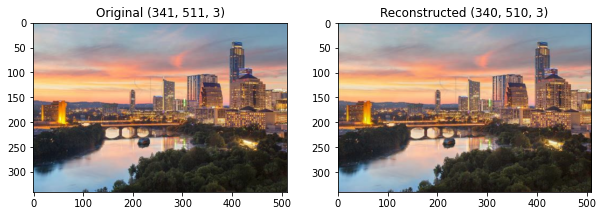

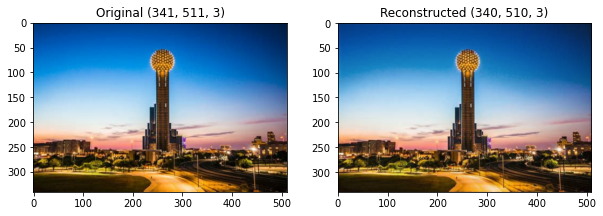

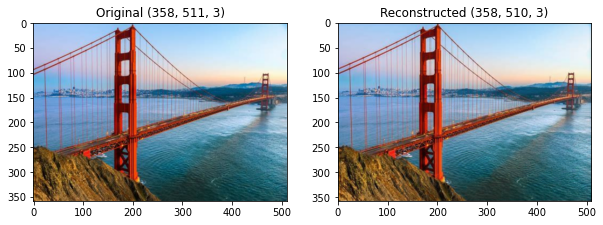

In [23]:
austin_file = os.path.join('../data', 'austin.jpeg')
dallas_file = os.path.join('../data', 'dallas.jpeg')
goldengate_file = os.path.join('../data','goldengate.jpeg')

austin_img = load_img(austin_file)
dallas_img = load_img(dallas_file)
goldengate_img = load_img(goldengate_file)

austin_r = AE.O2(AE.D2(AE.E2(tf.constant(austin_img))))
dallas_r = AE.O2(AE.D2(AE.E2(tf.constant(dallas_img))))
goldengate_r = AE.O2(AE.D2(AE.E2(tf.constant(goldengate_img))))

imglist = [austin_img, dallas_img, goldengate_img]
reclist = [austin_r, dallas_r, goldengate_r]

for orig, rec in zip(imglist, reclist):
    orig = tf.clip_by_value(tf.squeeze(orig), 0, 1)
    rec = tf.clip_by_value(tf.squeeze(rec), 0, 1)
    
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    imshow(orig,'Original')
    plt.subplot(1,2,2)
    imshow(rec,'Reconstructed')

Above we see that the autoencoder successfully reconstructed the original images with very few (if any) noticable artifacts. 

## Whitening and Coloring Transform

The Whitening and Coloring transform allows you to decouple the original style and the content from an image and apply another style to create a new image with the original content but with a new style. This transform is proposed by Li et al here: https://arxiv.org/abs/1705.08086

We will use this transform to apply the style of the image below to our images of Austin, Dallas, and the Golden Gate Bridge. 

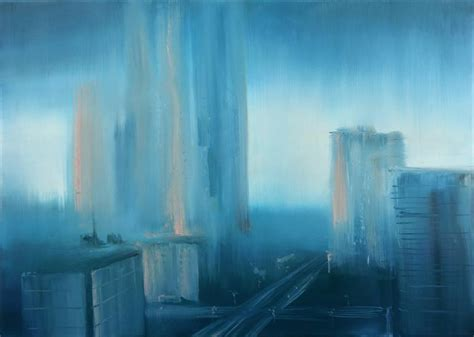

CPU times: user 16.3 s, sys: 6.5 s, total: 22.8 s
Wall time: 3.23 s


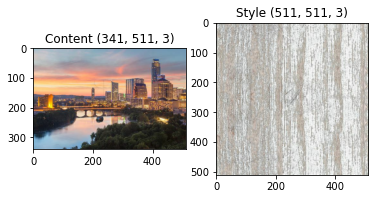

In [34]:
%%time

style_path = '../data/wooden.jpeg'

style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(austin_img,'Content')

plt.subplot(1, 2, 2)
imshow(style_image,'Style')

tmp = {'style':style_image, 
       'content':content_image}

alphas = {'layer3':0.8, 'layer2':0.6, 'layer1':0.6}
decoded_images = AE(tmp, transform='covmatch', alphas=alphas)

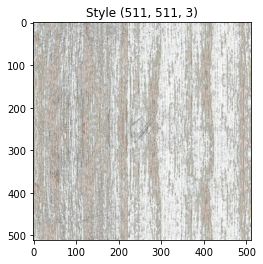

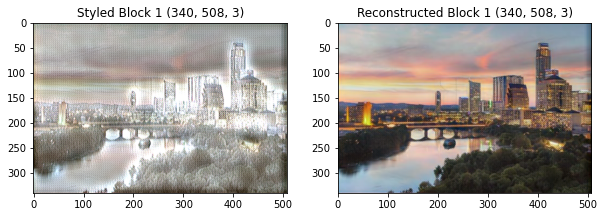

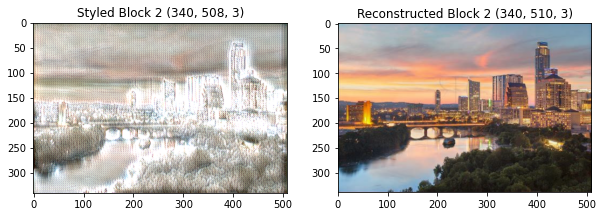

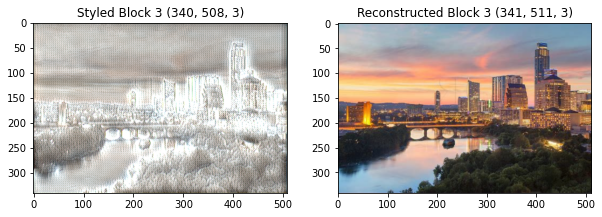

In [35]:
imshow(style_image,'Style')
for i, layer in enumerate(decoded_images.keys()):
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    imshow(decoded_images[layer][0],f'Styled Block {i+1}')
    plt.subplot(1,2,2)
    imshow(decoded_images[layer][1],f'Reconstructed Block {i+1}')